In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
import pandas as pd


from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D, ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend
from tensorflow_examples.models.pix2pix import pix2pix ##  a module within the tensorflow_examples package that provides an implementation of the Pix2Pix model for image-to-image translation (to install 1. download git portable version and then type - pip install "git+https://github.com/tensorflow/examples.git")
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import losses
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from zipfile import ZipFile
import os
import glob
from IPython.display import Image, display, Markdown, clear_output

<b> 1. Import and Understand the data
<b><br> A. Import and read ‘images.npy’.

[[[207 158  99]
  [213 167 107]
  [219 173 114]
  ...
  [141 146  66]
  [158 155  76]
  [176 163  84]]

 [[211 165 105]
  [218 174 113]
  [225 180 123]
  ...
  [139 144  62]
  [157 154  73]
  [176 165  85]]

 [[209 169 107]
  [218 178 117]
  [227 187 128]
  ...
  [134 142  57]
  [150 152  68]
  [168 162  78]]

 ...

 [[255 200 206]
  [228 150 164]
  [174  62  87]
  ...
  [215 208 154]
  [209 202 148]
  [217 210 155]]

 [[238 174 191]
  [189 103 128]
  [195  75 110]
  ...
  [228 221 166]
  [225 218 163]
  [219 213 155]]

 [[233 163 191]
  [185  94 127]
  [191  66 106]
  ...
  [233 226 171]
  [230 224 166]
  [229 223 163]]]


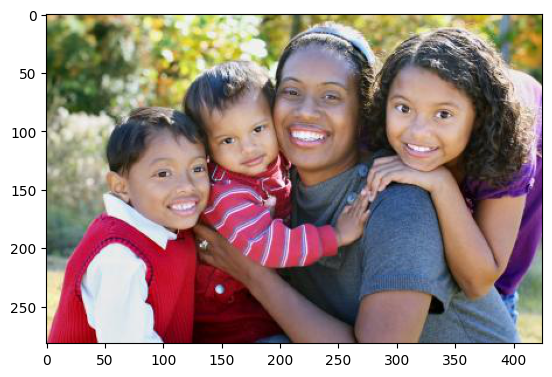

In [2]:
data = np.load('images.npy', allow_pickle=True)


#prinitng image
print(data[70][0]);
plt.imshow(data[70][0]);

<b>B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [3]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  """ assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel. 
  The alpha channel is a special channel that handles transparency. When an image has an alpha channel on it, 
  it means you can adjust the image's opacity levels and make bits translucent or totally see-through. 
  The alpha channel is instrumental when you want to remove the background from an image."""
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"Shape of X(features) is '{X.shape}' and the shape of masks(labels) is '{masks.shape}' ")

Exception 260 Grayscale image with shape (224, 224)
Shape of X(features) is '(393, 224, 224, 3)' and the shape of masks(labels) is '(393, 224, 224)' 


<b>C. Split the data into train and test (70:30 ratio). [1 Marks]

In [4]:
#splitting into X & Y test and train
x_train, x_test, y_train, y_test = train_test_split(X, masks, test_size=.30, random_state=1)

<b>D. Select random image from the train data and display original image and masked image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


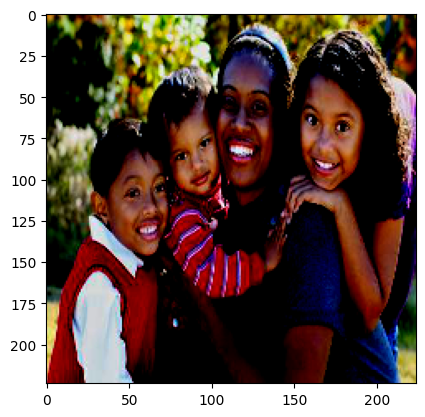

In [5]:
#original image
plt.imshow(x_train[33]);

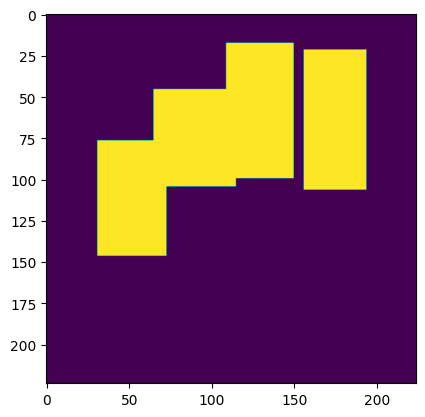

In [6]:
#masked image
plt.imshow(y_train[33]);

<b>2. Model building
<br>A. Design a face mask detection model.

In [7]:
backend.clear_session()
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

In [8]:
#getting the pre trained model MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False, alpha=1.0, weights="imagenet")

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 112*112
    'block_3_expand_relu',   # 56*56
    'block_6_expand_relu',   # 28*28
    'block_13_expand_relu',  # 14*14
    'block_16_project',      # 7*7
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
down_stack.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 1,841,984 (7.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,841,984 (7.03 MB)

In [9]:
#adding upsampling the image
up_stack = [
    pix2pix.upsample(512, 3), #7 - 14
    pix2pix.upsample(256, 3),  #14 - 28   
    pix2pix.upsample(128, 3),  #28 - 56
    pix2pix.upsample(64, 3),  #56 - 112
]

The up_stack list creates an upsampling stack for the decoder part of the U-Net model, which is used to generate the final segmentation mask for the input image. The upsample() layers in the decoder stack help to increase the spatial resolution of the feature maps, while preserving the semantic information learned by the encoder layers. The resulting upsampling stack can be combined with the feature extraction model created in the encoder part of the U-Net model to form a complete image segmentation model.

In [10]:
OUTPUT_CHANNELS = 1

 #This sets the number of output channels for the model to 3. In image segmentation tasks, the number of output channels typically
 # corresponds to the number of classes that the model needs to segment the input image into.
 #For example, if the model needs to segment the input image into foreground and background,
 #then the output channels would be set to 2. In this case, the output channels are set to 3, which may indicate that the model needs to
 #segment the input image into three classes, such as different types of objects or regions of interest.

In [11]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])
  print(x, skips)

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])


  #last = tf.keras.layers.Conv2DTranspose(output_channels, 2, padding='same', activation="sigmoid")
  last = tf.keras.layers.Conv2DTranspose(
    output_channels, 3, strides=2,
    padding='same', activation="sigmoid")  #112 -> 224
  x = last(x)


  return tf.keras.Model(inputs=inputs, outputs=x)

<b>B. Design your own Dice Coefficient and Loss function.

In [12]:
#dice coeff
def dice(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    dice_cal = numerator / (denominator + epsilon())
    return dice_cal

In [13]:
#loss func
def loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) - log(dice(y_true, y_pred) + epsilon())
    return loss

<b>C. Train and tune the model as required.

The function creates a U-Net model for image segmentation using the feature extraction model and upsampling stack defined earlier. The model takes in images of size 128x128 with 3 color channels (RGB), and outputs the final segmentation mask with the specified number of output channels. The model uses skip connections that allow it to combine the high-level semantic information learned by the encoder layers with the detailed spatial information learned by the decoder layers

In [14]:
model = unet_model(OUTPUT_CHANNELS)

model.compile(optimizer='adam',
              loss= loss,
              metrics=[dice, 'accuracy'])             
              
model.summary()

<KerasTensor shape=(None, 7, 7, 320), dtype=float32, sparse=False, name=keras_tensor_159> <list_reverseiterator object at 0x000002BA612681C0>


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 112, 112, │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 56,   │            │                   │
│                     │ 56, 144), (None,  │            │                   │
│                     │ 28, 28, 192),     │            │                   │
│                     │ (None, 14, 14,    │            │                   │
│                     │ 576), (None, 7,   │            │                   │
│                     │ 7, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 14, 14,    │  1,476,608 │ functional[0][4]  │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14, 14,    │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 28, 28,    │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 56, 56,    │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 56, 56,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 112, 112,  │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 112, 112,  │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 224, 224,  │      1,441 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,501,345 (24.80 MB)

 Trainable params: 4,657,441 (17.77 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

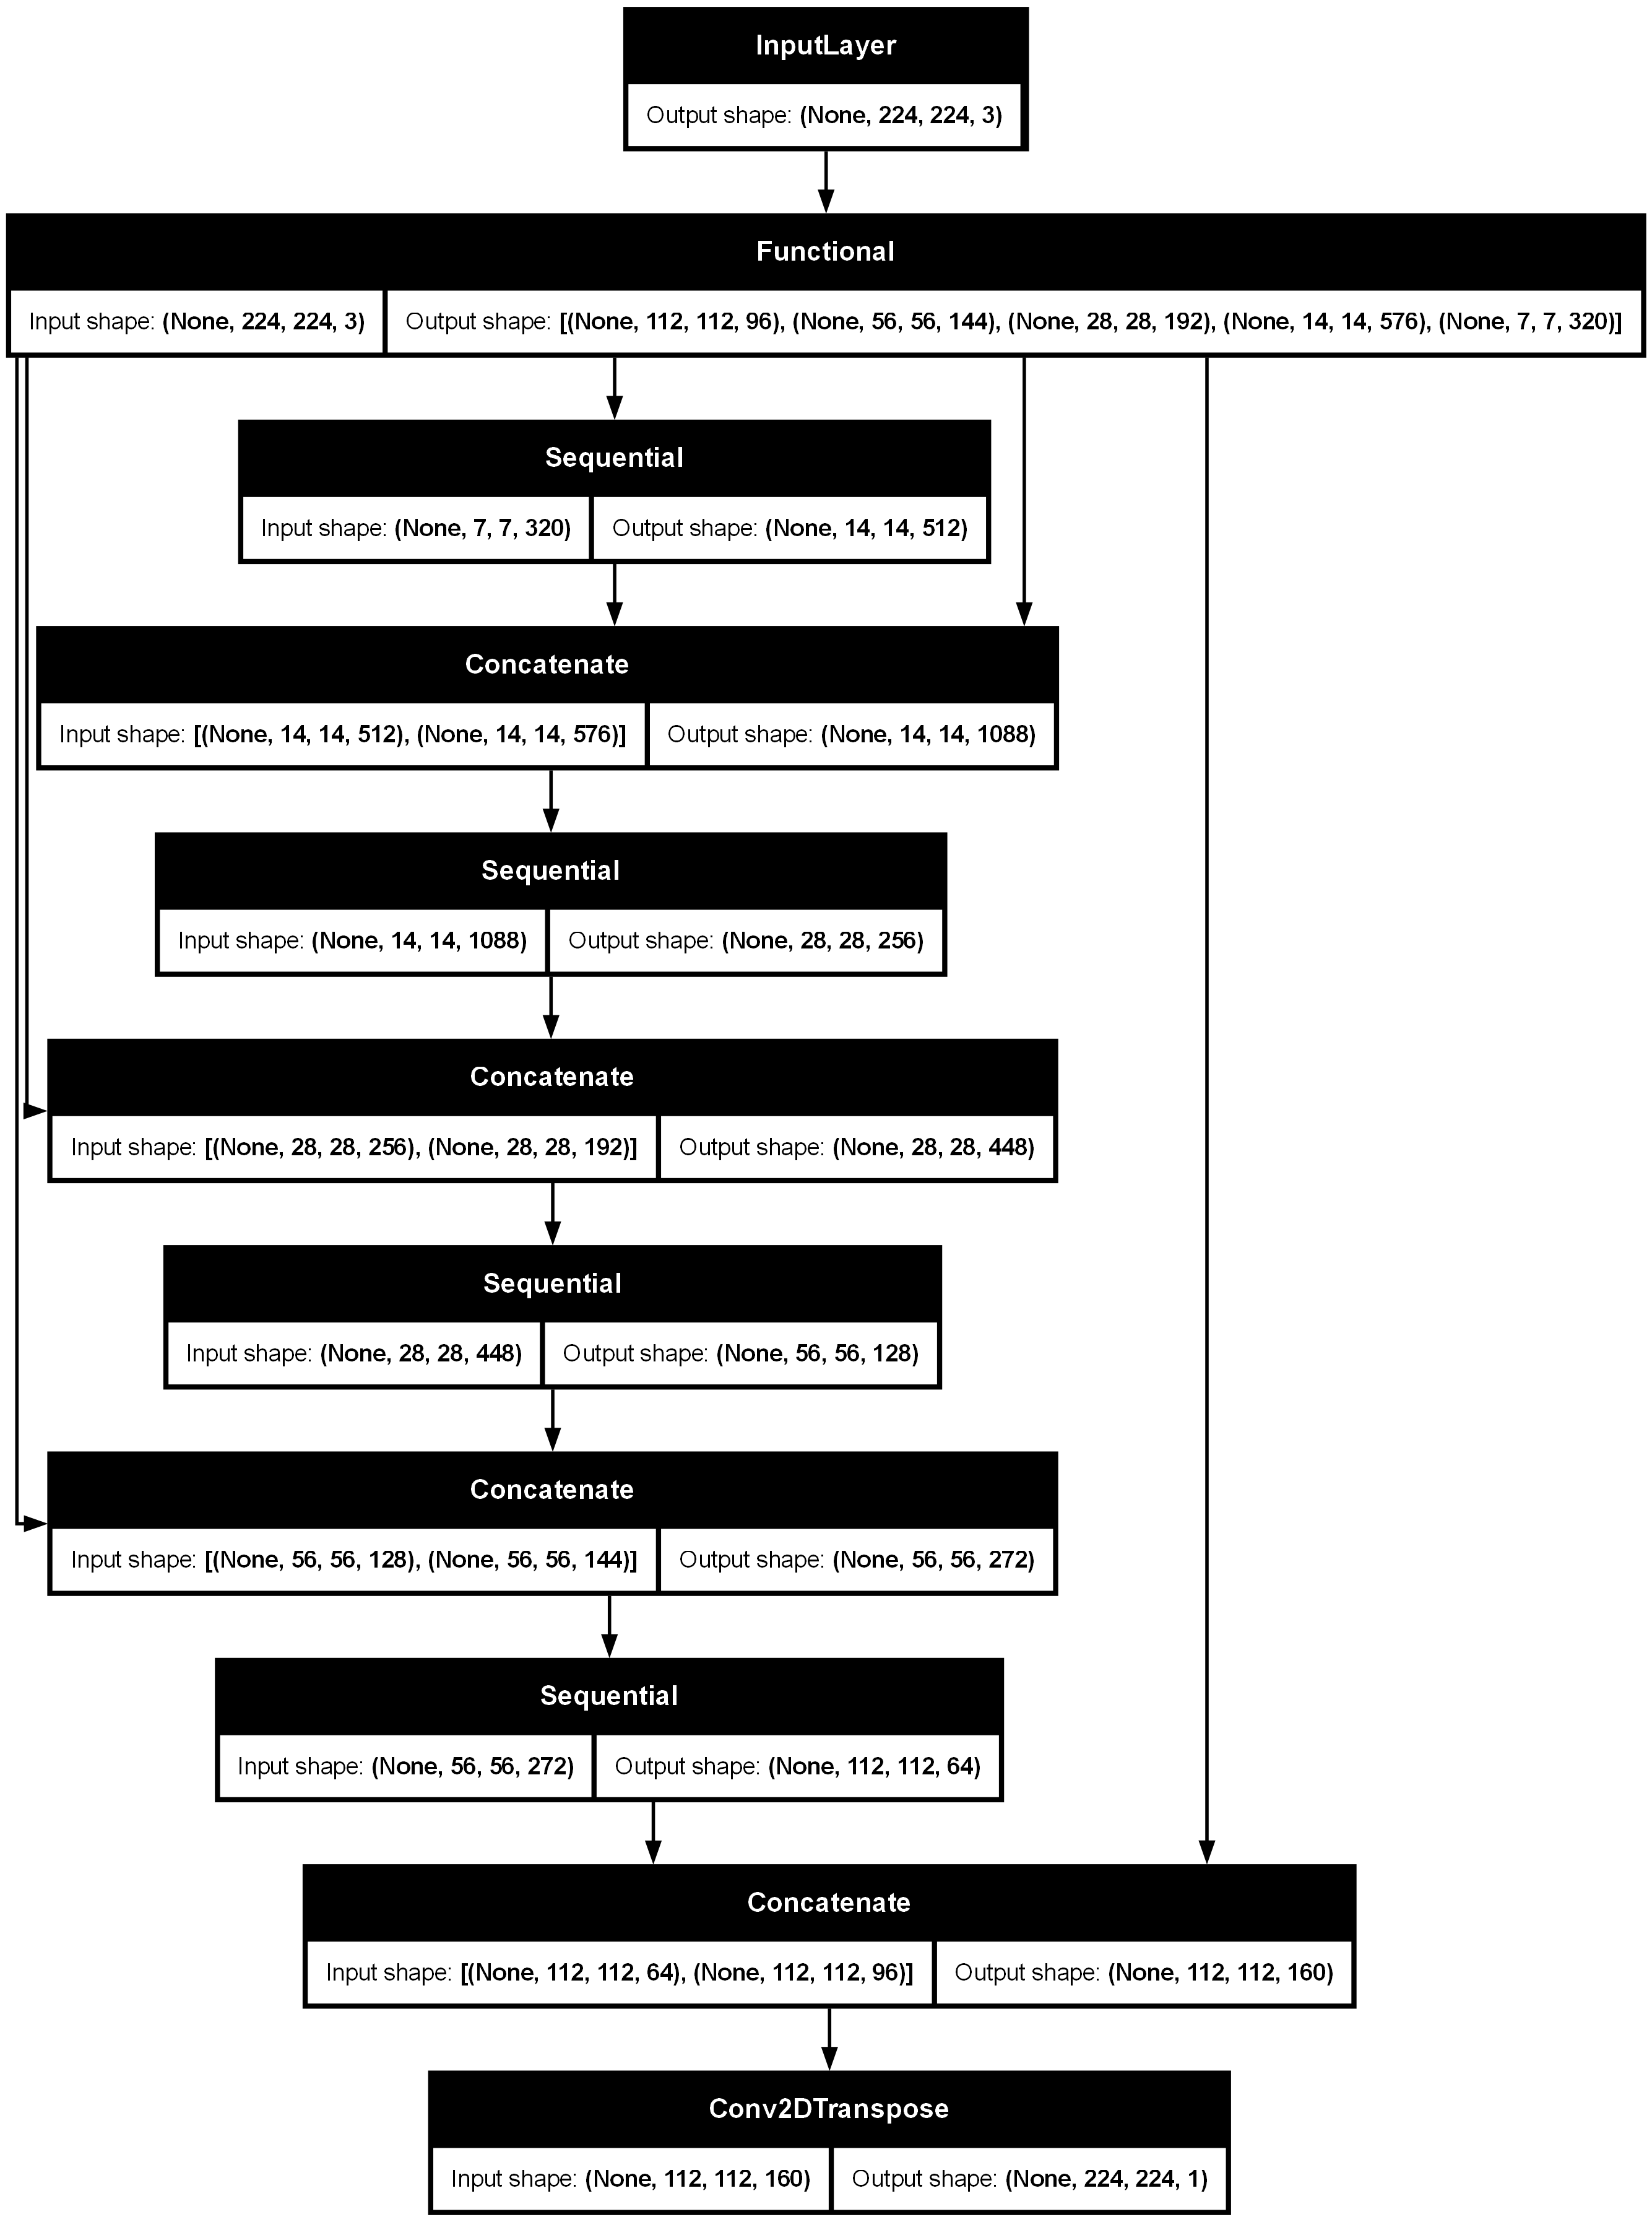

In [15]:
tf.keras.utils.plot_model(model, to_file = 'df.png', show_shapes=True)

In [16]:
#callbacks parameter tuning
checkpoint = ModelCheckpoint("/temp/test.weights.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [17]:
#training the modedl
model_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/10
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8906 - dice: 0.1221 - loss: 1.2861
Epoch 1: loss improved from inf to 1.05518, saving model to /temp/test.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.8907 - dice: 0.1222 - loss: 1.2844 - val_accuracy: 0.9006 - val_dice: 0.1565 - val_loss: 1.0723 - learning_rate: 0.0010
Epoch 2/10
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9219 - dice: 0.1246 - loss: 0.8526
Epoch 2: loss improved from 1.05518 to 0.87160, saving model to /temp/test.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.9219 - dice: 0.1247 - loss: 0.8527 - val_accuracy: 0.9148 - val_dice: 0.1422 - val_loss: 0.8742 - learning_rate: 0.0010
Epoch 3/10
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9265 - dice: 0.1271 - loss: 0.7971
Epoch 3: loss improved from 0.87160 to 0.81293, saving model to /temp/test.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.9265 - dice: 0.1271 - loss: 0

<b>D. Evaluate and share insights on performance of the model.

In [18]:
pd.DataFrame(model_history.history)

,accuracy,dice,loss,val_accuracy,val_dice,val_loss,learning_rate
0,0.907654,0.128684,1.055182,0.900648,0.156530,1.072326,0.001
1,0.920430,0.132298,0.871596,0.914845,0.142225,0.874220,0.001
2,0.925571,0.135198,0.812935,0.915958,0.138935,0.857939,0.001
3,0.929847,0.137680,0.764638,0.915651,0.141113,0.850722,0.001
4,0.933531,0.139750,0.722251,0.915566,0.139333,0.861136,0.001
5,0.936911,0.141658,0.683555,0.915972,0.138850,0.866918,0.001
6,0.940366,0.143466,0.642746,0.915546,0.139638,0.888142,0.001
7,0.943833,0.144983,0.603190,0.916428,0.136596,0.892779,0.001
8,0.947416,0.146744,0.558770,0.913455,0.144034,0.898208,0.001
9,0.951309,0.148465,0.517807,0.914338,0.138254,0.925798,0.001


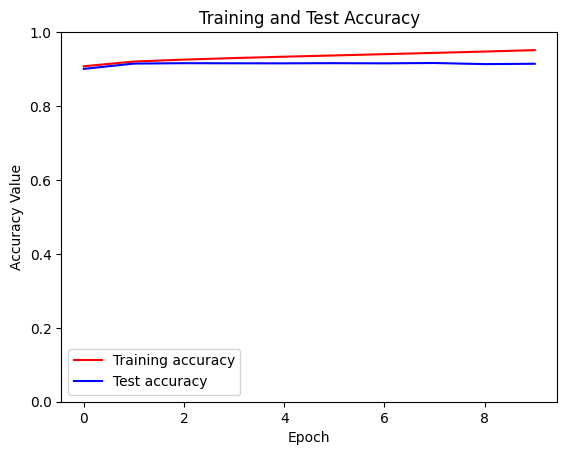

In [19]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(10)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

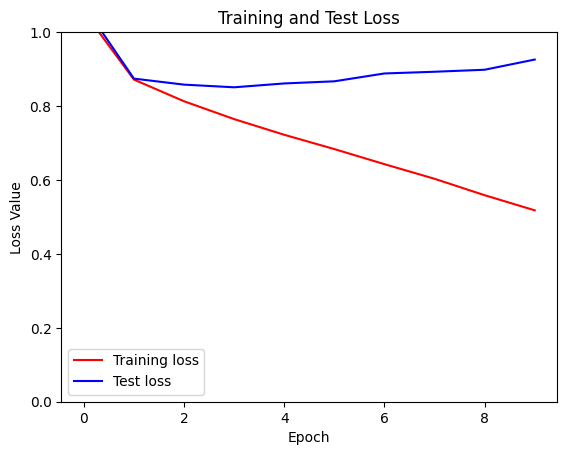

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(10)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

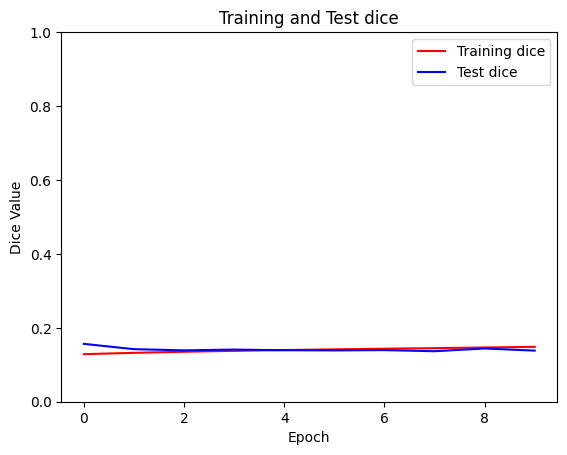

In [21]:
dice = model_history.history['dice']
val_dice = model_history.history['val_dice']

epochs = range(10)

plt.figure()
plt.plot(epochs, dice, 'r', label='Training dice')
plt.plot(epochs, val_dice, 'b', label='Test dice')
plt.title('Training and Test dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

#### 1. Training and Validation Accuracy:
* The training accuracy starts at around 0.90 and steadily increases, reaching a value of around 0.95 by the 10th epoch.
* The validation accuracy also follows a similar trend, increasing to approximately 0.91–0.92 by the final epoch.
* Both curves in the "Training and Test Accuracy" plot indicate that the model is learning well, with the test accuracy closely tracking the training accuracy, suggesting a low risk of overfitting.
####  2. Training and Validation Loss: 
*  The training loss decreases steadily from around 1.05 to about 0.51, indicating consistent learning by the model.
* The validation loss, however, does not decrease as smoothly. After an initial drop, it increases slightly towards the end (from around epoch 5). This could be a sign of overfitting or issues with the generalization of the model.
####  3. Dice Coefficient: 
* The dice coefficient improves across epochs, both for training and validation. The training dice increases from around 0.12 to 0.15 by the last epoch, while the validation dice follows a similar pattern but remains slightly lower.
* This suggests that while the model is learning, it is not perfectly aligned between training and validation for segmentation-related tasks (as indicated by the dice score).
#### 4. Overfitting Signs: 
*  While the accuracy is quite high, the divergence between training and validation losses from epoch 5 onwards is a sign of overfitting. The training loss keeps decreasing, while the validation loss starts to increase slightly, indicating that the model may be starting to memorize the training data instead of generalizing well to new data.
*  The dice scores for validation also show this pattern with less improvement beyond epoch 5.
#### Recommendations:
* Consider using regularization techniques like dropout, weight decay, or early stopping to prevent overfitting.
* Tuning the learning rate or using learning rate schedulers might also help with the increasing validation loss.
* Augmenting the data or collecting more diverse samples for validation might further improve the model’s ability to generalize.

<b>3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

In [22]:
ind = 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


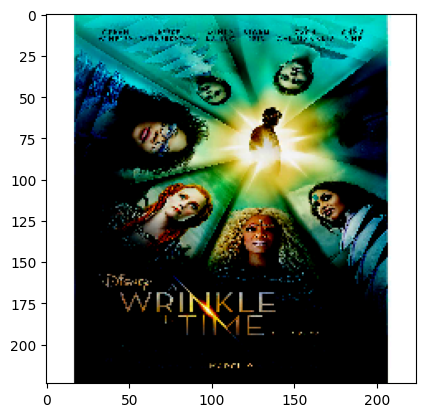

In [23]:
#x_test image
plt.imshow(x_test[ind]);

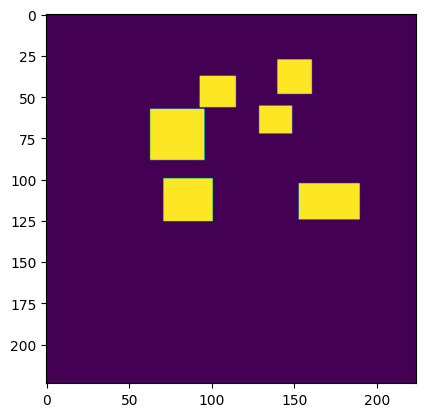

In [24]:
#y_test image
plt.imshow(y_test[ind]);

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step


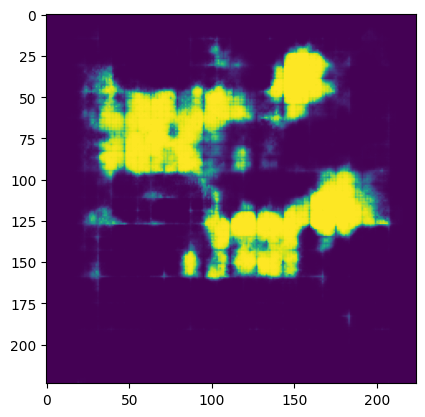

In [25]:
#y_predicted
y_pred = model.predict(np.array(x_test))
plt.imshow(y_pred[ind]);

In [26]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([x_test[ind]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT)) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


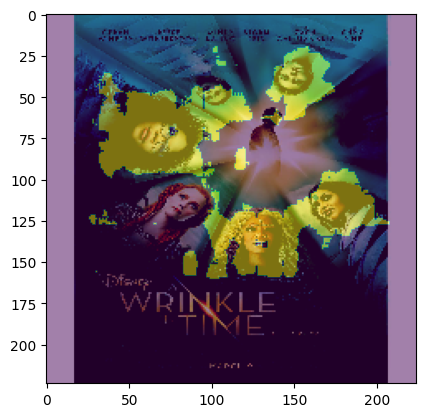

In [28]:
plt.imshow(x_test[ind])
plt.imshow(pred_mask, alpha=0.5)